In [2]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
from gc import collect

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

from collections import Counter
import cv2

from sklearn.cluster import MiniBatchKMeans, KMeans
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

In [2]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [4]:
flipkart = pd.read_pickle('flipkart_cleaned.pkl')
print(flipkart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   product_name  1050 non-null   object  
 1   image         1050 non-null   object  
 2   description   1050 non-null   object  
 3   class         1050 non-null   category
dtypes: category(1), object(3)
memory usage: 25.8+ KB
None


In [3]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

import os
import gc
from collections import Counter
import cv2

from sklearn.cluster import MiniBatchKMeans, KMeans
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [4]:
image_df = globals()['flipkart']
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.7+ KB
None


# Analyse exploratoire sur les images

Lors de l'analyse pré-exploratoire, on a gardé la colonne `image` qui contient les noms de fichiers avec extension.<br>
Regardons l'analyse sur la taille des images présentes dans le dataset.

In [5]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

In [6]:
def extract_img_features(image_names_list, path):
    img_height = []
    img_width = []
    img_channels = []
    img_size = []

    for img in image_names_list:
        image = cv2.imread(path + img)
        img_height.append(image.shape[0])
        img_width.append(image.shape[1])
        img_channels.append(image.shape[2])
        img_size.append(image.size)

    return pd.DataFrame({'height': img_height, 'width': img_width, 'channels': img_channels, 'size': img_size})
    del(image, img_height, img_width, img_channels, img_size)
    gc.collect()

In [7]:
image_df = pd.concat([image_df, extract_img_features(image_df['image'], path)], axis=1)
print(image_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   image     1050 non-null   object  
 1   class     1050 non-null   category
 2   height    1050 non-null   int64   
 3   width     1050 non-null   int64   
 4   channels  1050 non-null   int64   
 5   size      1050 non-null   int64   
dtypes: category(1), int64(4), object(1)
memory usage: 42.5+ KB
None


In [8]:
# Aperçu des statistiques descriptives des features extraites
print(image_df.select_dtypes(include='int').describe())

             height        width  channels          size
count   1050.000000  1050.000000    1050.0  1.050000e+03
mean    1220.038095  1196.570476       3.0  5.748901e+06
std      744.841368   864.076765       0.0  1.175770e+07
min      160.000000   145.000000       3.0  1.740000e+05
25%      844.000000   747.250000       3.0  2.017125e+06
50%     1100.000000  1100.000000       3.0  3.047550e+06
75%     1360.000000  1214.250000       3.0  4.661820e+06
max    11042.000000  8484.000000       3.0  2.810410e+08


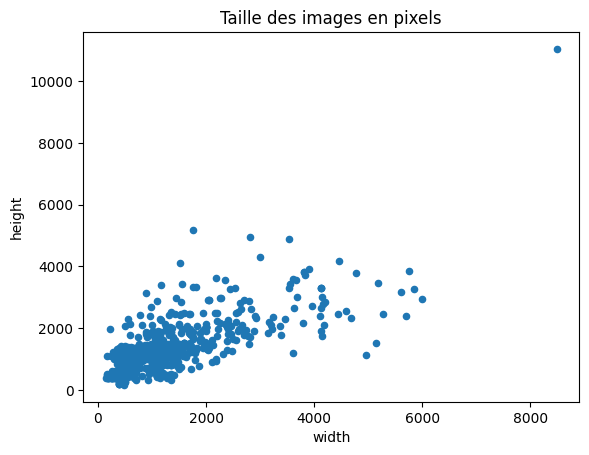

In [9]:
# Scatter plot de la taille des images
image_df.filter(["height", "width"]).plot(kind='scatter', x='width', y='height')
plt.title("Taille des images en pixels")
plt.show()

On constate qu'il y a tout type de taille d'image dont un outlier avec une taille extrêmement grande.<br>
Dans le cas des descripteurs SIFT, il est préférable de redimensionner les images avec un palier de dimension maximum pour améliorer la qualité et la rapidité de calcul.


Je conserve la liste des labels uniques sous une variable pour faciliter les traitements ultérieurs:

In [10]:
# Récupère les labels uniques dans une liste
list_labels = list(image_df['class'].unique())
print(list_labels)

['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


In [12]:
def detect_salt_and_pepper_noise(image, threshold=50):
    noisy = np.zeros_like(image)
    # Parcourir chaque pixel (sauf les bords)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            window = image[i-1:i+2, j-1:j+2]
            median = np.median(window)
            if abs(image[i,j] - median) > threshold:
                noisy[i,j] = 255
    return noisy


In [15]:
image_test = cv2.imread(path + image_df['image'][0], cv2.IMREAD_GRAYSCALE)

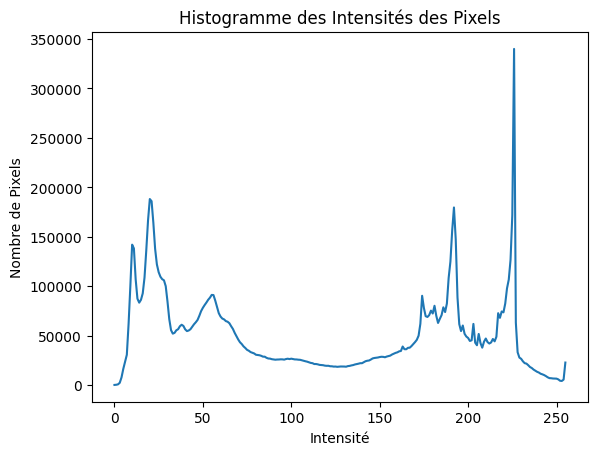

In [17]:
# Calculer l'histogramme
hist = cv2.calcHist([image_test], [0], None, [256], [0,256])

# Afficher l'histogramme
plt.plot(hist)
plt.title('Histogramme des Intensités des Pixels')
plt.xlabel('Intensité')
plt.ylabel('Nombre de Pixels')
plt.show()

In [18]:
hist

array([[2.56000e+02],
       [4.20000e+02],
       [8.26000e+02],
       [2.40900e+03],
       [7.86200e+03],
       [1.64590e+04],
       [2.35590e+04],
       [3.07500e+04],
       [6.20460e+04],
       [1.00463e+05],
       [1.42087e+05],
       [1.38301e+05],
       [1.07013e+05],
       [8.74590e+04],
       [8.34250e+04],
       [8.63190e+04],
       [9.28420e+04],
       [1.08753e+05],
       [1.36380e+05],
       [1.66789e+05],
       [1.88207e+05],
       [1.86021e+05],
       [1.64210e+05],
       [1.37857e+05],
       [1.22097e+05],
       [1.14258e+05],
       [1.09651e+05],
       [1.07183e+05],
       [1.06035e+05],
       [1.00111e+05],
       [8.45310e+04],
       [6.67780e+04],
       [5.56850e+04],
       [5.20990e+04],
       [5.29270e+04],
       [5.55170e+04],
       [5.65850e+04],
       [5.95520e+04],
       [6.10950e+04],
       [5.98850e+04],
       [5.64580e+04],
       [5.46940e+04],
       [5.52860e+04],
       [5.66030e+04],
       [5.90800e+04],
       [6.

In [16]:
noisy_pixels = detect_salt_and_pepper_noise(image_test, threshold=50)
plt.imshow(noisy_pixels, cmap='gray')
plt.title('Pixels Bruités Détectés')
plt.show()

KeyboardInterrupt: 

# CNN

Test des différents modèles de CNN pour l'étude de faisabilité

In [11]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0

In [12]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

In [13]:
def extract_embeddings(model, images, path, preprocess_input):
    input_shape = model.input.shape
    input_size = (input_shape[1], input_shape[2])
    print(f"Input size: {input_size}")
    last_layer = model.layers[-2]
    model = Model(inputs=model.inputs, outputs=last_layer.output)
    images_embeddings = []
    for img in images:
        clear_output()
        image = cv2.imread(path + img)
        image = cv2.resize(image, input_size)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        image_embedding = model.predict(image)
        images_embeddings.append(image_embedding)
    images_embeddings = np.asarray(images_embeddings)
    return images_embeddings

In [14]:
def ARI_cnn(images, embeddings, n_clusters=7):
    # Affiche la taile des embeddings
    print('Raw shape: ', embeddings.shape)
    embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
    print('Flat shape: ', embeddings_flat.shape)

    # Réduction de la dimensionnalité des embeddings
    pca = PCA(n_components=0.95)

    # Fit et transforme les embeddings
    embeddings_pca = pca.fit_transform(embeddings_flat)
    # Affiche la taille des embeddings après PCA
    print('PCA shape: ', embeddings_pca.shape)

    # Crée le modèle KMeans
    n_clusters = n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings_pca)

    ari = adjusted_rand_score(images, clusters)
    print(f"Adjusted Rand Index: {ari}")
    return ari

In [15]:
embeddings = extract_embeddings(VGG16(), image_df['image'], path, vgg16_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

KeyboardInterrupt: 

In [67]:
embeddings = extract_embeddings(ResNet50(), image_df['image'], path, resnet50_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Raw shape:  (1050, 1, 2048)
Flat shape:  (1050, 2048)
PCA shape:  (1050, 412)
Adjusted Rand Index: 0.41595772766026823


0.41595772766026823

In [68]:
embeddings = extract_embeddings(InceptionV3(), image_df['image'], path, inception_v3_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Raw shape:  (1050, 1, 2048)
Flat shape:  (1050, 2048)
PCA shape:  (1050, 411)
Adjusted Rand Index: 0.4929040017460021


0.4929040017460021

In [69]:
embeddings = extract_embeddings(EfficientNetB0(), image_df['image'], path, efficientnet_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Raw shape:  (1050, 1, 1280)
Flat shape:  (1050, 1280)
PCA shape:  (1050, 416)
Adjusted Rand Index: 0.5004776367526101


0.5004776367526101

## Visualisation des résultats

On va retenir le modèle EfficientNetB0 pour regarder la visualisation des résultats:

In [70]:
# Paramètres pour T-SNE
tsne = TSNE(n_components=2, perplexity=30, 
                     max_iter=2000, init='random', random_state=42)

# Paramètres pour PCA
pca = PCA(n_components=0.95)
pca_vector = pca.fit_transform(embeddings.reshape(embeddings.shape[0], -1))
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(pca_vector)
X_tsne = tsne.fit_transform(pca_vector)
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = image_df['class']
df_tsne["labels"] = kmeans.labels_
df_tsne['class'] = df_tsne['class'].astype('category')

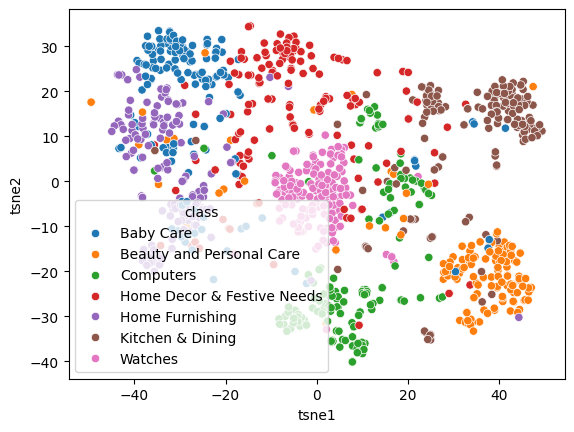

In [71]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='class')
plt.show()

<Axes: xlabel='tsne1', ylabel='tsne2'>

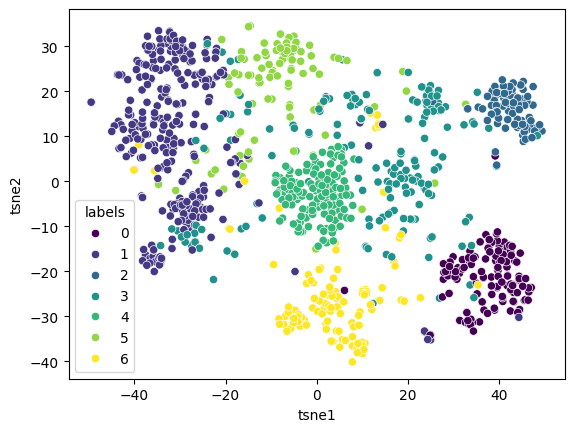

In [72]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='labels', palette='viridis')

# VISUAL BAG OF WORDS

On va tester différents paramètres pour évaluer si les descripteurs SIFT nous permettent de distinguer de manière non supervisée les images.<br>
Suite à l'analyse des images, on va considérer les paramètres suivants à tester :
* Redimensionnement des images en 600x600 et 300x300 maximum (2)
    * Déterminer une sélection de 3 clusters à retenir évaluer l'ARI (3)
        * Compression PCA à 0.95 (1)


**Soit un total de 6 combinaisons à tester.**

In [16]:
ari_scores = list()

## Définition des fonctions utilisés pour tester les diffèrentes combinaisons de paramètres

In [17]:
def custom_resize(height, width, max_size, path, image):
    # Choisis la valeur maximale entre la hauteur et la largeur
    max_value = max(height, width)
    # Calcule le ratio pour redimensionner l'image sans déformer l'aspect ratio
    ratio = max_size / max_value
    height = int(height * ratio)
    width = int(width * ratio)
    # Lit et redimensionne l'image aux nouvelles dimensions avec une interpolation bilinéaire par défaut
    image = cv2.imread(path + image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (height, width), interpolation=cv2.INTER_LINEAR)
    # Efface les variables intermédiaires
    del(max_value, ratio, height, width)
    gc.collect()
    # Retourne l'image
    return image

In [43]:
def extract_descriptors(df, path, max_size:int=None, resize:tuple=None, truncate:float=None):
    sift_descriptors = []
    # Itere sur le fataframe
    for row in tqdm(df.itertuples()):
        # Si max_size est défini, redimensionne l'image si elle dépasse la valeur de max_size soit en hauteur ou en largeur
        if max_size is not None:
            if row.height > max_size or row.width > max_size:
                image = custom_resize(row.height, row.width, max_size, path, row.image)
        # Si resize est défini, redimensionne l'image aux dimensions spécifiées avec une interpolation bilinéaire
        elif resize is not None:
            image = cv2.imread(path + row.image, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, resize, interpolation=cv2.INTER_LINEAR)
        else:
            image = cv2.imread(path + row.image, cv2.IMREAD_GRAYSCALE)
        # Applique l'histogramme égalisé sur l'image
        image = cv2.equalizeHist(image)
        # Initialise l'objet SIFT
        sift = cv2.SIFT_create()
        # Détecte et calcule les descripteurs SIFT avec une normalisation L2 intégré au processus
        _, descriptors = sift.detectAndCompute(image, None)
        # Si truncate est défini, tronque les descripteurs à 0.2
        if truncate is not None:
            descriptors = np.clip(descriptors, 0, truncate)
            # Renormalise les descripteurs
            descriptors /= np.linalg.norm(descriptors, axis=1, keepdims=True)
        sift_descriptors.append(descriptors)
    # Efface les variables intermédiaires
    del(image, sift, descriptors)
    gc.collect()
    # Retourne le descripteur normalisé à la norme L2
    return sift_descriptors
    


In [51]:
# Fonction pour déterminer un range de cluster à tester pour déterminer le nombre optimal de Visual Words
def cluster_range(X, list_labels, n=10):
    if n<2:
        raise ValueError("Le nombre de clusters doit être supérieur à 2")  
    
    # Détermination du nombre de clusters avec la racine carrée du nombre de descriptors
    n_clusters_sqrt = int(np.sqrt(len(X)))
    print("Nombre de clusters - méthode racine carrée : ", n_clusters_sqrt)

    # Détermination du nombre de clusters par multiplier par 10 le nombre de labels existants
    n_clusters_ten = len(list_labels) * 10
    print("Nombre de clusters - méthode nbre_labels * 10 : ", n_clusters_ten)

    if n==2:
        rng_clusters = [n_clusters_ten, n_clusters_sqrt]
    else:
        # Création d'une liste de n clusters à tester
        rng_clusters = np.linspace(n_clusters_ten, n_clusters_sqrt, n).astype(int)
    print("Longueur de la liste de clusters à tester: ", len(rng_clusters))

    return rng_clusters

In [20]:
# Fonction pour retourner les centroides selon un nombre de clusters choisis
def return_inertia_labels(X, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    return inertia, labels

In [21]:
def plot_optimalk(X, rng_clusters):    
    # Tester plusieurs valeurs de clusters pour trouver le meilleur
    inertia_list = []
    labels_list = []
    for n_clusters in tqdm(rng_clusters):
        inertia, labels = return_inertia_labels(X, n_clusters)
        inertia_list.append(inertia)
        labels_list.append(labels)
    
    # Détermine le optimal-K avec la méthode du coude
    optimal_k = KneeLocator(rng_clusters, inertia_list, curve='convex', direction='decreasing').elbow
    # Affiche la courbe d'inertie en fonction du nombre de clusters
    plt.figure(figsize=(12, 6))
    plt.plot(rng_clusters, inertia_list, marker='o')
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.title('Inertie en fonction du nombre de clusters')
    plt.legend()
    plt.grid()
    plt.show()
    return optimal_k

In [38]:
def return_histogram_normalized(descriptors, kmeans, n_cluster):
    labels = kmeans.predict(descriptors)
    hist = Counter(labels)
    hist = dict(sorted(hist.items()))
    # Convertit le dictionnaire en array de longeur n_cluster
    hist = np.array([hist.get(i) if i in hist.keys() else 0 for i in range(n_cluster)])
    # Normalise l'histogramme
    hist = hist / hist.sum()
    # Supprime les variables intermédaires
    del(labels)
    gc.collect()
    # Retourne l'histogramme
    return hist

In [40]:
# Fonction pour retourner les centroides selon un nombre de clusters choisis
def return_model(X, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans

In [57]:
def return_vbow(X, n_cluster, sift_descriptors):
    kmeans = return_model(X, n_cluster)
    vbow = []
    for descriptors in tqdm(sift_descriptors):
        hist = return_histogram_normalized(descriptors, kmeans, n_cluster)
        vbow.append(hist)
    vbow = np.array(vbow)
    return vbow

## Test des combinaisons de paramètres

In [41]:
sift_descriptors = extract_descriptors(image_df, path)

1050it [08:49,  1.98it/s]


In [67]:
sift_descriptors_trunc = extract_descriptors(image_df, path, truncate=0.2)

677it [07:13,  1.52it/s]

In [46]:
sift_descriptors_224 = extract_descriptors(image_df, path, resize=(224, 224))

1050it [00:19, 54.25it/s]


In [47]:
sift_descriptors_224_truncated = extract_descriptors(image_df, path, resize=(224, 224), truncate=0.2)

1050it [00:25, 40.78it/s]


In [48]:
sift_descriptors_300_max = extract_descriptors(image_df, path, max_size=300)

1050it [03:06,  5.63it/s]


In [55]:
# SCENARIO 1 - descripteurs SIFT non redimensionné

# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X, list_labels, n=2)

Points d'intérêts / descripteurs image :  (9051350, 128)
Nombre de clusters - méthode racine carrée :  3008
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  2


In [60]:
# Définition pour le taux de réduction de la pca
pca_threshold = [0.95]

# Itère sur les clusters à tester
for cluster in rng_clusters:
    vbow = return_vbow(X, cluster, sift_descriptors)
    for ts in pca_threshold:
        pca = PCA(n_components=ts)
        pca_vector = pca.fit_transform(vbow)
        kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
        kmeans.fit(pca_vector)
        ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
        ari_scores.append(("Descripteurs avec taille des images par défaut", cluster, ari, ts))

# Affichage des résultats
for ari in ari_scores:
    print(f"max_size: {ari[0]}    -      n_clusters: {ari[2]}    -    ARI: {ari[2]}     -   PCA: {ari[3]}")

100%|██████████| 1050/1050 [07:03<00:00,  2.48it/s]


max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.061645270263956956    -    ARI: 0.061645270263956956     -   PCA: 0.95
max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.0552422314156641    -    ARI: 0.0552422314156641     -   PCA: 0.95


Points d'intérêts / descripteurs image :  (407435, 128)
Nombre de clusters - méthode racine carrée :  638
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  10


100%|██████████| 10/10 [02:05<00:00, 12.53s/it]


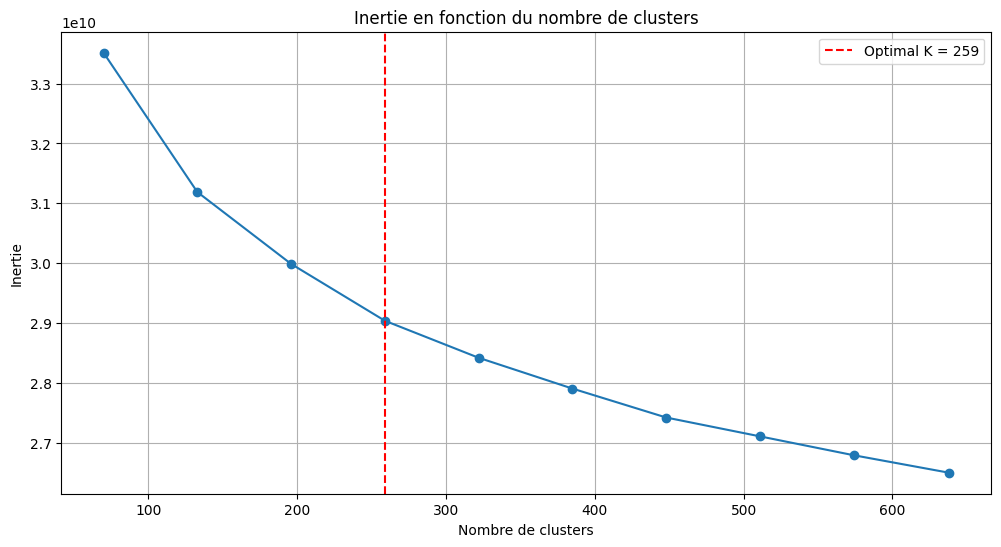

In [61]:
# SCENARIO 2 - descripteurs SIFT avec redimensionnement custom à 300 pixels

# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors_300_max, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X, list_labels)

# Affiche la courbe d'inertie en fonction du nombre de clusters
k = plot_optimalk(X, rng_clusters)

In [62]:
# Définit la liste des clusters à tester avec nos 3 sélections de clusters (méthode labels, méthode du coude et méthode racine carrée)
clusters = [k]

# Définition pour le taux de réduction de la pca
pca_threshold = [0.95, 0.99]

# Itère sur les clusters à tester
for cluster in clusters:
    vbow = return_vbow(X, cluster, sift_descriptors_300_max)
    for ts in pca_threshold:
        pca = PCA(n_components=ts)
        pca_vector = pca.fit_transform(vbow)
        kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
        kmeans.fit(pca_vector)
        ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
        ari_scores.append(("Descripteurs avec taille des images avec un seuil à 300 max", cluster, ari, ts))

# Affichage des résultats
for ari in ari_scores:
    print(f"max_size: {ari[0]}    -      n_clusters: {ari[2]}    -    ARI: {ari[2]}     -   PCA: {ari[3]}")

100%|██████████| 1050/1050 [04:49<00:00,  3.63it/s]


max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.061645270263956956    -    ARI: 0.061645270263956956     -   PCA: 0.95
max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.0552422314156641    -    ARI: 0.0552422314156641     -   PCA: 0.95
max_size: Descripteurs avec taille des images avec un seuil à 300 max    -      n_clusters: 0.0502832767066807    -    ARI: 0.0502832767066807     -   PCA: 0.95
max_size: Descripteurs avec taille des images avec un seuil à 300 max    -      n_clusters: 0.02330556248060301    -    ARI: 0.02330556248060301     -   PCA: 0.99


Points d'intérêts / descripteurs image :  (336131, 128)
Nombre de clusters - méthode racine carrée :  579
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  10


100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


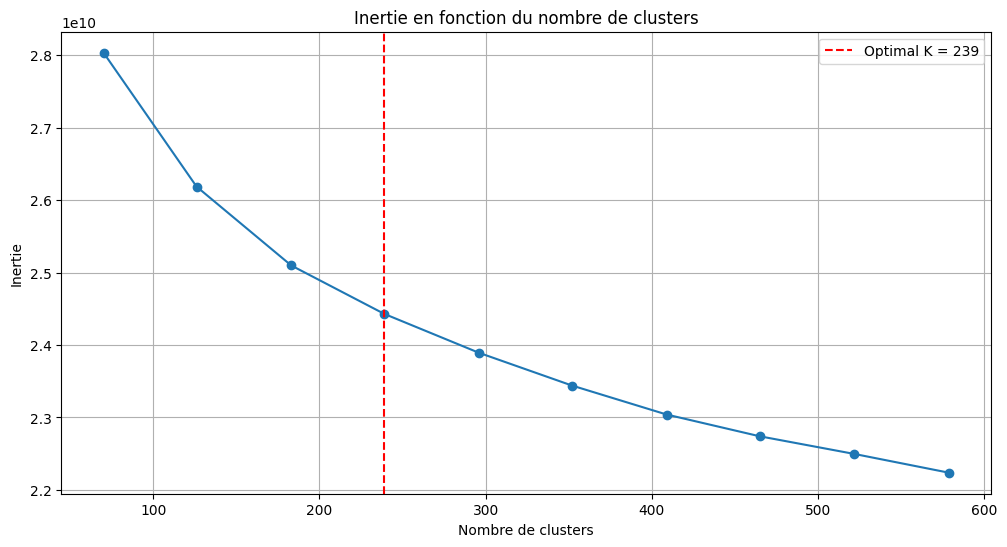

In [63]:
# SCENARIO 3 - descripteurs SIFT avec redimensionnement resize à (224, 224)

# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors_224, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X, list_labels)

# Affiche la courbe d'inertie en fonction du nombre de clusters
k = plot_optimalk(X, rng_clusters)

In [64]:
# Définit la liste des clusters à tester avec nos 3 sélections de clusters (méthode labels, méthode du coude et méthode racine carrée)
clusters = [k]

# Définition pour le taux de réduction de la pca
pca_threshold = [0.95, 0.99]

# Itère sur les clusters à tester
for cluster in clusters:
    vbow = return_vbow(X, cluster, sift_descriptors_224)
    for ts in pca_threshold:
        pca = PCA(n_components=ts)
        pca_vector = pca.fit_transform(vbow)
        kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
        kmeans.fit(pca_vector)
        ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
        ari_scores.append(("Descripteurs avec taille des images à 224x224", cluster, ari, ts))

# Affichage des résultats
for ari in ari_scores:
    print(f"max_size: {ari[0]}    -      n_clusters: {ari[2]}    -    ARI: {ari[2]}     -   PCA: {ari[3]}")

100%|██████████| 1050/1050 [04:33<00:00,  3.84it/s]


max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.061645270263956956    -    ARI: 0.061645270263956956     -   PCA: 0.95
max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.0552422314156641    -    ARI: 0.0552422314156641     -   PCA: 0.95
max_size: Descripteurs avec taille des images avec un seuil à 300 max    -      n_clusters: 0.0502832767066807    -    ARI: 0.0502832767066807     -   PCA: 0.95
max_size: Descripteurs avec taille des images avec un seuil à 300 max    -      n_clusters: 0.02330556248060301    -    ARI: 0.02330556248060301     -   PCA: 0.99
max_size: Descripteurs avec taille des images à 224x224    -      n_clusters: 0.05006027740265655    -    ARI: 0.05006027740265655     -   PCA: 0.95
max_size: Descripteurs avec taille des images à 224x224    -      n_clusters: 0.05020036587066524    -    ARI: 0.05020036587066524     -   PCA: 0.99


Points d'intérêts / descripteurs image :  (336131, 128)
Nombre de clusters - méthode racine carrée :  579
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  10


100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


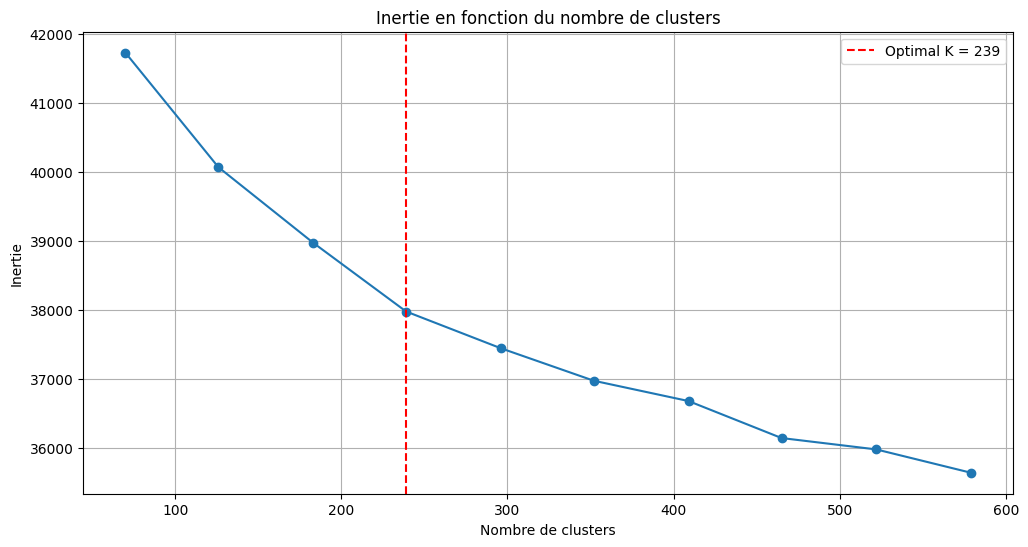

In [65]:
# SCENARIO 4 - descripteurs SIFT avec redimensionnement resize à (224, 224) avec une troncature des descripteurs à 0.2

# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors_224_truncated, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X, list_labels)

# Au vu de la complexité en terme de calcul, on va réduire le nombre de clusters à tester au min et max de la liste
k = plot_optimalk(X, rng_clusters)

In [66]:
# Définit la liste des clusters à tester avec nos 3 sélections de clusters (méthode labels, méthode du coude et méthode racine carrée)
clusters = [k]

# Définition pour le taux de réduction de la pca
pca_threshold = [0.95]

# Itère sur les clusters à tester
for cluster in clusters:
    vbow = return_vbow(X, cluster, sift_descriptors_224_truncated)
    for ts in pca_threshold:
        pca = PCA(n_components=ts)
        pca_vector = pca.fit_transform(vbow)
        kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
        kmeans.fit(pca_vector)
        ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
        ari_scores.append(("Descripteurs avec taille des images à 224x224 et une troncature à 0.2", cluster, ari, ts))

# Affichage des résultats
for ari in ari_scores:
    print(f"max_size: {ari[0]}    -      n_clusters: {ari[2]}    -    ARI: {ari[2]}     -   PCA: {ari[3]}")

100%|██████████| 1050/1050 [04:37<00:00,  3.78it/s]


max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.061645270263956956    -    ARI: 0.061645270263956956     -   PCA: 0.95
max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.0552422314156641    -    ARI: 0.0552422314156641     -   PCA: 0.95
max_size: Descripteurs avec taille des images avec un seuil à 300 max    -      n_clusters: 0.0502832767066807    -    ARI: 0.0502832767066807     -   PCA: 0.95
max_size: Descripteurs avec taille des images avec un seuil à 300 max    -      n_clusters: 0.02330556248060301    -    ARI: 0.02330556248060301     -   PCA: 0.99
max_size: Descripteurs avec taille des images à 224x224    -      n_clusters: 0.05006027740265655    -    ARI: 0.05006027740265655     -   PCA: 0.95
max_size: Descripteurs avec taille des images à 224x224    -      n_clusters: 0.05020036587066524    -    ARI: 0.05020036587066524     -   PCA: 0.99
max_size: Descripteurs avec taille des images à 224x224 et une troncature à 0.

In [ ]:
# SCENARIO 5 - descripteurs SIFT non redimensionné

# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors_trunc, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X, list_labels, n=2)

Points d'intérêts / descripteurs image :  (9051350, 128)
Nombre de clusters - méthode racine carrée :  3008
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  2


In [ ]:
# Définition pour le taux de réduction de la pca
pca_threshold = [0.95]

# Itère sur les clusters à tester
for cluster in rng_clusters:
    vbow = return_vbow(X, cluster, sift_descriptors_trunc)
    for ts in pca_threshold:
        pca = PCA(n_components=ts)
        pca_vector = pca.fit_transform(vbow)
        kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
        kmeans.fit(pca_vector)
        ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
        ari_scores.append(("Descripteurs avec taille des images par défaut", cluster, ari, ts))

# Affichage des résultats
for ari in ari_scores:
    print(f"max_size: {ari[0]}    -      n_clusters: {ari[2]}    -    ARI: {ari[2]}     -   PCA: {ari[3]}")

100%|██████████| 1050/1050 [07:03<00:00,  2.48it/s]


max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.061645270263956956    -    ARI: 0.061645270263956956     -   PCA: 0.95
max_size: Descripteurs avec taille des images par défaut    -      n_clusters: 0.0552422314156641    -    ARI: 0.0552422314156641     -   PCA: 0.95


## VISUALISATION DES RESULTATS

In [185]:
del(sift_descriptors_600, X, ari_scores, ari, clusters, rng_clusters)
gc.collect()

15

In [189]:
params = (sift_descriptors_300, 0.95, 7, 315)
X = np.concatenate(params[0], axis=0)

# Paramètres pour T-SNE
tsne = TSNE(n_components=2, perplexity=30, 
                     max_iter=2000, init='random', random_state=42)

hist_vector = return_hist_vector(X, params[3], params[0])
pca = PCA(n_components=params[1])
pca_vector = pca.fit_transform(hist_vector)
kmeans = KMeans(n_clusters=params[2], random_state=42)
kmeans.fit(pca_vector)
X_tsne = tsne.fit_transform(pca_vector)
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = image_df['class']
df_tsne["labels"] = kmeans.labels_
df_tsne['class'] = df_tsne['class'].astype('category')

100%|██████████| 1050/1050 [00:11<00:00, 88.87it/s]


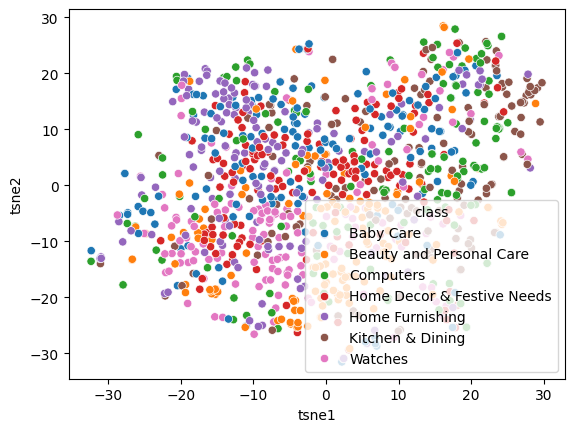

In [190]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='class')
plt.show()

<Axes: xlabel='tsne1', ylabel='tsne2'>

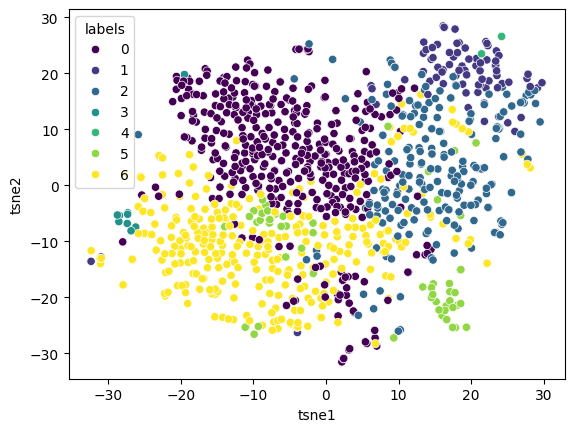

In [192]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='labels', palette='viridis')